# Decision Tree & Ensemble Learning

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

## Gini impurity and Entropy


#### Gini impurity

Measures the impurity of the data points in a set and is used to evaluate how good a split is when the CART algorithm searches for the best pair of feature and the threshold.

To compute Gini impurity for a set of items with J classes, suppose $i \in \{1, 2, \dots, J\}$ and let $p_i$ be the fraction of items labeled with class i in the set.
\begin{align}
I(p) = 1 - \sum_{i=1}^J p_i^2
\end{align}

The following function calculates the gini impurity for a given set of data points. Even tough the sci-kit learn package would do it internally its good to have the intuition.

In [2]:
def gini_impurity(x):
    
    unique, counts = np.unique(x, return_counts=True)
    probabilities = counts / sum(counts)
    gini = 1 - sum([p*p for p in probabilities])

    return gini

In [3]:
np.testing.assert_equal(0, gini_impurity(np.array([1, 1, 1])))
np.testing.assert_equal(0.5, gini_impurity(np.array([1, 0, 1, 0])))
np.testing.assert_equal(3/4, gini_impurity(np.array(['a', 'b', 'c', 'd'])))
np.testing.assert_almost_equal(2.0/3, gini_impurity(np.array([1, 2, 3, 1, 2, 3])))

#### Entropy

Another popular measure of impurity is the entropy, and is calculated as follows:
\begin{align}
I(p) = - \sum_{i=1}^J p_i log_2{p_i}
\end{align}


In [4]:
def entropy(x):
   
    unique, counts = np.unique(x,return_counts=True)
    probabilities = counts / sum(counts)
    # e = sum([-p*(np.log(p)/np.log(2)) for p in probabilities]) // same thing to create base 2 log
    e = sum([-p*np.log2(p) for p in probabilities])

    return e

In [5]:
np.testing.assert_equal(0, entropy(np.array([1, 1, 1])))
np.testing.assert_equal(1.0, entropy(np.array([1, 0, 1, 0])))
np.testing.assert_equal(2.0, entropy(np.array(['a', 'b', 'c', 'd'])))
np.testing.assert_almost_equal(1.58496, entropy(np.array([1, 2, 3, 1, 2, 3])), 4)

## Iris dataset

We'll be applying several machine learning models under the well famous iris dataset.
The Iris data set contains the morphologic variation of Iris flowers of three related species (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each observation (see image below):
- Sepal.Length: sepal length in centimeters.
- Sepal.Width: sepal width in centimeters.
- Petal.Length: petal length in centimeters.
- Petal.Width: petal width in centimeters.

<table>
  <tr>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg" style="width:250px"></td>
    <td><img src="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg" width="250px"></td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg" width="250px"></td>
  </tr>
  <tr>
    <td>Iris setosa</td>
    <td>Iris versicolor</td>
    <td>Iris virginica</td>
  </tr>
</table>


In [6]:
train = pd.read_csv('Iristrain.csv')
test = pd.read_csv('Iristest.csv')

train_x = train.iloc[:,0:4]
train_y = train.iloc[:,4]

test_x = test.iloc[:,0:4]
test_y = test.iloc[:,4]


print(train_y.value_counts().sort_index())
print(test_y.value_counts().sort_index())

Iris-setosa        34
Iris-versicolor    32
Iris-virginica     39
Name: species, dtype: int64
Iris-setosa        16
Iris-versicolor    18
Iris-virginica     11
Name: species, dtype: int64


### Decision Tree Classifier



***Creating a decision tree with max_depth of 2.***

In [7]:
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=2)

#### Prediction with Decision tree

With this simple decision tree above, we can apply it to make predictions on the test dataset and evaluate its performance.

Making predictions using the trained decision tree model on the test data.

In [8]:
test_z = dtc.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9111111111111111
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  3  8]]


#### Hyper-parameters

Training the decision trees with increasing number of maximum depth and plot its performance.

For each value of max_depth, a decision tree model is trained and evaluated on both train and test data.

Text(0.5, 1.0, 'Accuracy by Max-Depth')

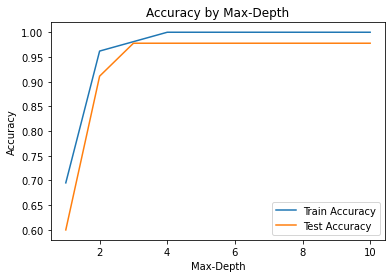

In [9]:
trainacc=[]
testacc=[]
for i in range(1,11):
  dtc = DecisionTreeClassifier(max_depth=i)
  dtc.fit(train_x, train_y)
  test_z = dtc.predict(test_x)
  testacc.append (accuracy_score(test_y, test_z))
  test_z = dtc.predict(train_x)
  trainacc.append (accuracy_score(train_y, test_z))

plt.plot(np.linspace(1,10,10),trainacc,label="Train Accuracy")
plt.plot(np.linspace(1,10,10),testacc,label="Test Accuracy")
plt.legend()
plt.xlabel('Max-Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy by Max-Depth')


#### Fine-tune the decision tree classifier

Fine-tunning the model to combat overfitting using grid search with 3-fold cross validation

In [10]:
parameters = {"criterion":['gini','entropy'],
              "max_depth": [1,2,3,4,5],
              "min_samples_split": [0.01,0.05,0.1,0.2]
              }

dt = DecisionTreeClassifier()
grid = GridSearchCV(dt,parameters, cv=3)
grid.fit (train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))

The best score is 0.9619047619047619
The best hyper parameter setting is {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 0.01}


#### Prediction and Evaluation

Applying this model to make predictions on the test data and evaluating its performance.

In [11]:
test_z= grid.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9777777777777777
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]


### Random Forest

**Applying a Random Forest together with Gridsearch to the Iris dataset and evaluating its accuracy.**

In [12]:
from sklearn.ensemble import RandomForestClassifier
parameters ={
    "criterion":['gini','entropy'],
    "n_estimators":[10,20,50],
    "max_depth": [2,3,4],
    "min_samples_split": [.005,.01,.02]
}

rfc_grid = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), parameters, cv=3)
rfc_grid.fit(train_x, train_y)

print("The best score is {}".format(rfc_grid.best_score_))
print("The best hyper parameter setting is {}".format(rfc_grid.best_params_))


The best score is 0.9619047619047619
The best hyper parameter setting is {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.005, 'n_estimators': 20}


In [13]:
test_z= rfc_grid.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9777777777777777
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]


### Adaboost

**Apply Adaboost together with Gridsearch to the Iris dataset and evaluating its accuracy.**

In [14]:
from sklearn.ensemble import AdaBoostClassifier
parameters = {
    "n_estimators": [20,40],
    "learning_rate": [0.01,0.1,1,10],
}

adaboost= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=0)
adaboost_grid = GridSearchCV(adaboost, parameters, cv=3, n_jobs=-1)
adaboost_grid.fit(train_x, train_y)

print("The best score is {}".format(adaboost_grid.best_score_))
print("The best hyper parameter setting is {}".format(adaboost_grid.best_params_))

The best score is 0.9619047619047619
The best hyper parameter setting is {'learning_rate': 0.1, 'n_estimators': 20}


In [15]:
test_z= adaboost_grid.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9777777777777777
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]


### Gradient Boosting

**Apply Boosting together with Gridsearch to the Iris dataset and evaluating its accuracy.**

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "loss": ["deviance"],
    "learning_rate": [0.01, 0.1],
    "min_samples_split": [.05,.1, .2],
    "max_depth":[2, 3, 4],
    "n_estimators":[80, 120, 150]
}

gbc_grid = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)
gbc_grid.fit(train_x, train_y)

print("The best score is {}".format(gbc_grid.best_score_))
print("The best hyper parameter setting is {}".format(gbc_grid.best_params_))


The best score is 0.9714285714285715
The best hyper parameter setting is {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'min_samples_split': 0.2, 'n_estimators': 150}


In [17]:
test_z= gbc_grid.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9777777777777777
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]


---

## California Housing Dataset

The California Housing dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). 

In [18]:
# Load train and test data from CSV files.
train = pd.read_csv('Californiatrain.csv')
test = pd.read_csv('Californiatest.csv')

train_x = train.iloc[:,0:8]
train_y = train.iloc[:,8]

test_x = test.iloc[:,0:8]
test_y = test.iloc[:,8]


In [19]:
#Decision Tree 
from sklearn.tree import DecisionTreeRegressor

parameters = {
              "max_depth": [50,100,200,500,1000],
              "min_samples_split": [0.001, 0.01,0.05,0.1]
              }

dt = DecisionTreeRegressor()
grid = GridSearchCV(dt,parameters, cv=3, n_jobs=-1)
grid.fit (train_x, train_y)

print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))

The best score is 0.7013701255997985
The best hyper parameter setting is {'max_depth': 1000, 'min_samples_split': 0.01}


In [20]:
from sklearn.metrics import r2_score
test_z= grid.predict(test_x)

print("model accuracy: {}".format(r2_score(test_y, test_z)))

model accuracy: 0.7117913544460708


In [21]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
parameters = {
    "learning_rate": [0.01, 0.1],
    "min_samples_split": [.001,.01, .1],
    "max_depth":[50,100, 200],
    "n_estimators":[50,100]
}

gbr_grid = GridSearchCV(GradientBoostingRegressor(), parameters, cv=3)
gbr_grid.fit(train_x, train_y)

print("The best score is {}".format(gbr_grid.best_score_))
print("The best hyper parameter setting is {}".format(gbr_grid.best_params_))

The best score is 0.8168887119390121
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 100, 'min_samples_split': 0.01, 'n_estimators': 100}


In [22]:
test_z= gbr_grid.predict(test_x)

print("model accuracy: {}".format(r2_score(test_y, test_z)))

model accuracy: 0.8277967335899288
